In [1]:
from prototype04_cbcsnrs import CBCSNRsBase, compute_bilby_snr
import numpy as np
import pylab as plt
import bilby
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
from pycbc.detector import Detector
from datetime import datetime

from TaylorF2_with_fLim import quintet

# modified Findchirp method, or Half Scaling method. 
* SNR : $$ \rho= \left( \frac{1 Mpc}{D_{eff}} \right)\mathcal{A}_{1Mpc} \sqrt{ 4\int_0^\infty \frac{f^{-7/3}}{S_n(f)}df } $$

* Half scaled SNR : $$ \rho_{1/2} = \left( \frac{D_{eff}}{1 Mpc} \right)\mathcal{A}_{1Mpc}^{-1} \times \rho $$
                    $$ \rho_{1/2} = \sqrt{ 4\int_0^\infty \frac{f^{-7/3}}{S_n(f)}df } $$
                    
* It shouldn't depend on the GW parameters
* It depends on the noise curve of the detector : $S_n(f)$

# taking care of units
* $\mathcal{M}$ : chirp mass in $M_{\odot}$, $\mathcal{D}$: luminosity distance in Mpc. 
* $F_+,F_{\times}$: Antenna pattern, $\iota$: inclination angle
$$\mathcal{A}_{1Mpc}=\left(\frac{5}{24\pi}\right)^{1/2}\left(\frac{GM_{\odot}/c^2}{1Mpc}\right)\left(\frac{\pi GM_{\odot}}{c^3}\right)^{-1/6}\left(\frac{\mathcal{M}}{M_{\odot}}\right)^{5/6} $$
$$ \mathcal{D}_{eff} = \mathcal{D}\left[ F_+^2\left(\frac{1+cos^2\iota}{2}\right)^2 + F_{\times}^2 cos^2\iota \right]^{-1/2} $$ 

* Half scaled SNR : 
$$ \rho_{1/2} = \left( \frac{D_{eff}}{1 Mpc} \right) \mathcal{M}^{-5/6} \times \rho $$
$$ \rho_{1/2} = \left(\frac{5}{24\pi}\right)^{1/2}\left(\frac{GM_{\odot}/c^2}{1Mpc}\right)\left(\frac{\pi GM_{\odot}}{c^3}\right)^{-1/6}\left(\frac{1}{M_{\odot}}\right)^{5/6} \sqrt{ 4\int_0^\infty \frac{f^{-7/3}}{S_n(f)}df } $$

* Putting a upper integration limit at $f_{ISCO}$ lower limit to a chosen $f_{min}$
$$ f_{ISCO} = \frac{f c^3}{ G M_{tot}\pi 6^{3/2} } $$
$$ \rho_{1/2} = \left(\frac{5}{24\pi}\right)^{1/2}\left(\frac{GM_{\odot}/c^2}{1Mpc}\right)\left(\frac{\pi GM_{\odot}}{c^3}\right)^{-1/6}\left(\frac{1}{M_{\odot}}\right)^{5/6} \sqrt{ 4\int_{f_{min}}^{f_{ISCO}} \frac{f^{-7/3}}{S_n(f)}df } $$

In [54]:
# initialized parameters shown below
# mtot_min, mtot_max, nsamples is needed for interpolation purposes
# nsamples = 100 is recomended and is expected to take 7s is mtot_min = 10. mtot_max = 219. 
# nsamples with higher value will give better result.
# it is recomended to do the initialization for BNS and BBH with appropriate mtot range
'''
__init__(self, mtot_min=2., mtot_max=439.6, nsamples=100, list_of_detectors=['L1', 'H1', 'V1'], sensitivity='O3', \
                duration=16., sampling_frequency=4096.,\
                waveform_arguments= dict(waveform_approximant = "TaylorF2", \
                                               reference_frequency = 20., minimum_frequency = 20))
'''
start_time = datetime.now()
quin_ = quintet(2.,439.6,1000)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:01:11.249662


## simple performance checks

In [25]:
# Bilby
quin_.compute_bilby_snr_(mass_1=np.array([10.,50.,100.,500.]), mass_2=np.array([10.,50.,100.,500.]))

{'opt_snr_net': array([161.52595333, 315.6661989 ,  78.9002118 ,   0.        ]),
 'L1': array([132.08275995, 261.76879278,  65.69651976,   0.        ]),
 'H1': array([ 84.00372897, 166.48315594,  41.78253576,   0.        ]),
 'V1': array([39.85162032, 58.35757916, 12.78399073,  0.        ])}

In [26]:
# with interpolation
quin_.snr(mass_1=np.array([10.,50.,100.,500.]), mass_2=np.array([10.,50.,100.,500.]))

{'opt_snr_net': array([161.42994058, 315.69027673,  79.46089016,   0.        ]),
 'L1': array([131.99949301, 261.78604139,  66.16504101,   0.        ]),
 'H1': array([ 83.95077177, 166.49412594,  42.08051206,   0.        ]),
 'V1': array([39.85006248, 58.37915193, 12.86277254,  0.        ])}

* notice how SNR decrease with mass
* mtot=1000 has $f_{lso}(f_{max})$ below 20Hz
* last stable orbit's frequency is calculated as, $f_{lso} = \frac{C^3}{ G(m_{tot})M_\odot\pi 6^{3/2} }$

# speed test
* bilby Vs interpolation with half SNR

In [60]:
# gerneral case, random parameters
# chirp mass can go upto only 95 if f_min=20. to get non zero SNR
nsamples = 1000
chirp_mass = np.linspace(10,100,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
mass_ratio = mass_2/mass_1
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra, dec, psi, phase = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [61]:
# error might occur for mchirp>95., if f_min=20. 
start_time = datetime.now()
bilby_ = quin_.compute_bilby_snr_(mass_1=mass_1, mass_2=mass_1, luminosity_distance=luminosity_distance, theta_jn=theta_jn, \
                            psi=psi, phase=phase, ra=ra, dec=dec)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:46.423727


* here is bilby is faster than usual as I have initialized the interferometer objects and PSDs commonly 
* also TaylorF2 is fast
* for 1 miilion points it will take 13.5hrs

In [62]:
start_time = datetime.now()
mine_ = quin_.snr(mass_1=mass_1, mass_2=mass_1, luminosity_distance=luminosity_distance, iota=theta_jn, \
            psi=psi, phase=phase, ra=ra, dec=dec)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:00.021190


* mine is 1773 times faster than that of bilby's
* for 1 miilion points it will take 4.5mins

## Accuracy checks
* SNR difference

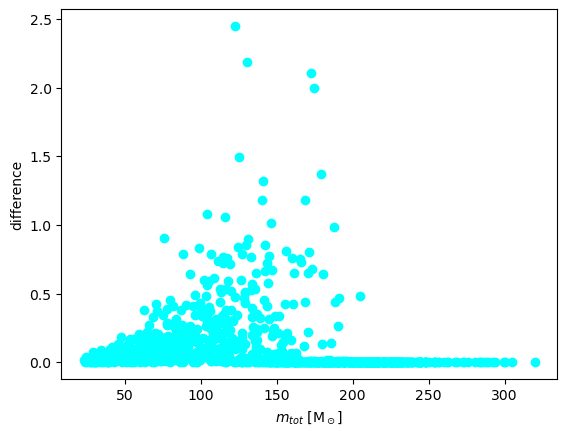

In [46]:
plt.plot(total_mass, abs(mine_['opt_snr_net']-bilby_['opt_snr_net']), 'o', color='cyan')
plt.xlabel(r"$m_{tot}$ [$\rm M_\odot$]")
plt.ylabel(r"difference")
plt.show()

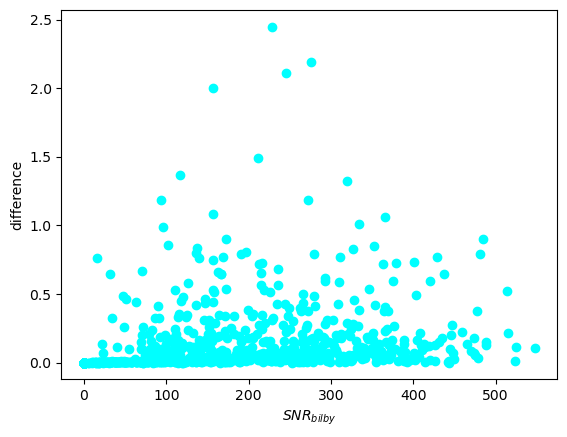

In [47]:
plt.plot(bilby_['opt_snr_net'], abs(mine_['opt_snr_net']-bilby_['opt_snr_net']), 'o', color='cyan')
plt.xlabel(r"$SNR_{bilby}$")
plt.ylabel(r"difference")
plt.show()

In [48]:
# looking that parameters with maximum error diff
index = np.argmax(mine_['opt_snr_net']-bilby_['opt_snr_net'])
print('mass_1=',mass_1[index], 'mass_2=',mass_1[index], 'luminosity_distance=',luminosity_distance[index], \
                         'theta_jn=',theta_jn[index], 'psi=',psi[index], 'phase=',phase[index], 'ra=',ra[index], 'dec=',dec[index])

mass_1= 88.81650794751845 mass_2= 88.81650794751845 luminosity_distance= 80.0 theta_jn= 0.06186165352674752 psi= 0.8267327640417725 phase= 3.301991745219168 ra= 4.839388829027608 dec= 1.1879515429616307


In [44]:
# bilby
quin_.compute_bilby_snr_(mass_1=mass_1[index], mass_2=mass_1[index], luminosity_distance=luminosity_distance[index], \
                         theta_jn=theta_jn[index], psi=psi[index], phase=phase[index], ra=ra[index], dec=dec[index])

{'opt_snr_net': array([227.84831516]),
 'L1': array([137.62056648]),
 'H1': array([177.60834545]),
 'V1': array([37.82472773])}

In [45]:
# mine
quin_.snr(mass_1=mass_1[index], mass_2=mass_1[index], luminosity_distance=luminosity_distance[index], iota=theta_jn[index], \
            psi=psi[index], phase=phase[index], ra=ra[index], dec=dec[index])

{'opt_snr_net': array([230.29688183]),
 'L1': array([139.11258514]),
 'H1': array([179.52245357]),
 'V1': array([38.15797561])}

### ploting at low SNR region
* this part will decide whether an event is detectable or not

In [59]:
bilby_['opt_snr_net']

array([128.68876943, 236.18174547, 474.12183829, 117.68501738,
       384.78385619,  90.08345433, 286.30720064, 202.14087721,
        82.04885627, 309.55549669, 120.38525491, 257.97764342,
       358.69410861, 315.28769555, 216.13625467, 316.07584032,
       179.14910902, 203.49173587, 208.60742245, 519.32425978,
       330.20382276, 449.85592424, 272.30619708, 239.70358898,
       187.17299207, 276.12066459, 322.86976634, 360.11742808,
       240.01590353, 244.43824236, 355.12223444,  50.8880069 ,
        78.97239164, 200.18500157, 230.86902662, 414.26888103,
       200.90757789, 433.85299868, 348.23542363,  57.25805773,
       255.71541159, 232.52750813,   0.        , 177.14213084,
       181.35468224,  80.56673452,  94.72425961, 165.86440095,
       169.28309672,  85.91183215])

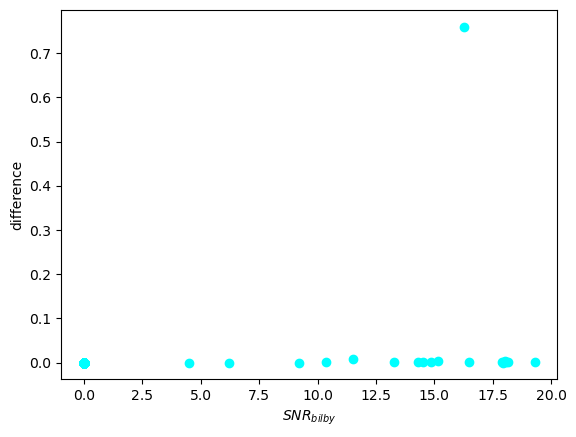

In [64]:
idx = bilby_['opt_snr_net']<20
xx =  bilby_['opt_snr_net'][idx]
yy = abs(mine_['opt_snr_net']-bilby_['opt_snr_net'])[idx]
plt.plot(xx, yy, 'o', color='cyan')
plt.xlabel(r"$SNR_{bilby}$")
plt.ylabel(r"difference")
plt.show()

In [65]:
# looking at the outlier point again
index = np.argmax((mine_['opt_snr_net']-bilby_['opt_snr_net'])[idx])
print('mass_1=',mass_1[index], 'mass_2=',mass_1[index], 'luminosity_distance=',luminosity_distance[index], \
                         'theta_jn=',theta_jn[index], 'psi=',psi[index], 'phase=',phase[index], 'ra=',ra[index], 'dec=',dec[index])

mass_1= 21.772106664881107 mass_2= 21.772106664881107 luminosity_distance= 80.0 theta_jn= 2.733977237263043 psi= 0.1166140940670483 phase= 2.6614338629260414 ra= 0.2354269963164389 dec= 1.3584885145573204


In [67]:
# bilby
quin_.compute_bilby_snr_(mass_1=mass_1[index], mass_2=mass_1[index], luminosity_distance=luminosity_distance[index], \
                         theta_jn=theta_jn[index], psi=psi[index], phase=phase[index], ra=ra[index], dec=dec[index])

{'opt_snr_net': array([354.41585186]),
 'L1': array([203.54009331]),
 'H1': array([236.13275939]),
 'V1': array([168.59224897])}

In [66]:
# mine
quin_.snr(mass_1=mass_1[index], mass_2=mass_1[index], luminosity_distance=luminosity_distance[index], iota=theta_jn[index], \
            psi=psi[index], phase=phase[index], ra=ra[index], dec=dec[index])

{'opt_snr_net': array([354.37240895]),
 'L1': array([203.52595449]),
 'H1': array([236.09804548]),
 'V1': array([168.56661292])}

* close enough

## Accuracy checks in BNS events
* SNR difference

In [2]:
quin_ = quintet(1.,10.,100)

In [6]:
# gerneral case, random parameters
# chirp mass can go upto only 95 if f_min=20.
nsamples = 100
chirp_mass = np.linspace(1,3,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
mass_ratio = mass_2/mass_1
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra, dec, psi, phase = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [7]:
bilby_ = quin_.compute_bilby_snr_(mass_1=mass_1, mass_2=mass_1, luminosity_distance=luminosity_distance, theta_jn=theta_jn, \
                            psi=psi, phase=phase, ra=ra, dec=dec)

mine_ = quin_.snr(mass_1=mass_1, mass_2=mass_1, luminosity_distance=luminosity_distance, iota=theta_jn, \
            psi=psi, phase=phase, ra=ra, dec=dec)

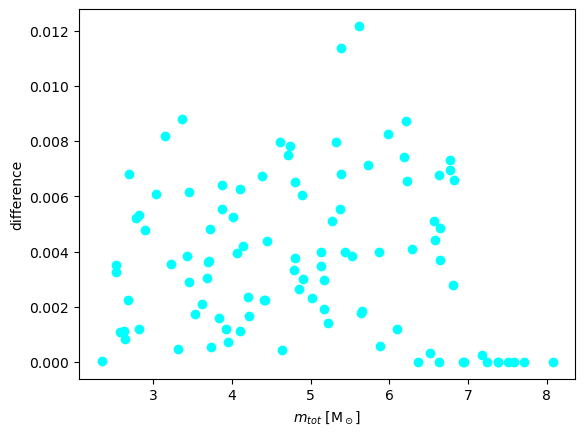

In [8]:
plt.plot(total_mass, abs(mine_['opt_snr_net']-bilby_['opt_snr_net']), 'o', color='cyan')
plt.xlabel(r"$m_{tot}$ [$\rm M_\odot$]")
plt.ylabel(r"difference")
plt.show()

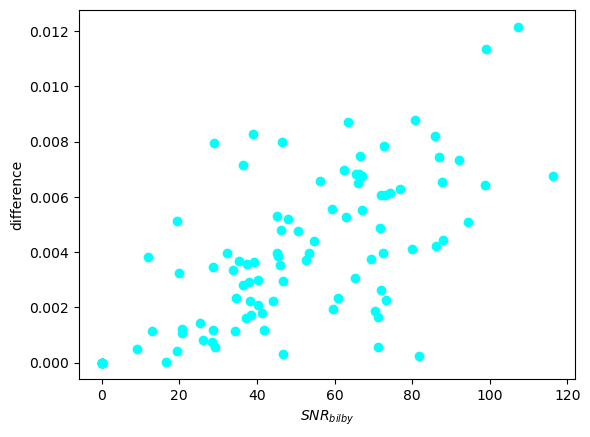

In [10]:
plt.plot(bilby_['opt_snr_net'], abs(mine_['opt_snr_net']-bilby_['opt_snr_net']), 'o', color='cyan')
plt.xlabel(r"$SNR_{bilby}$")
plt.ylabel(r"difference")
plt.show()

* a satisfying result